In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

import statsmodels.formula.api as smf
import lxml

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pd.options.display.float_format = '{:.4f}'.format

In [2]:
# import subprocess
# inputString = "This is some text that I would like to analyze. After it has finished, I will say \"Thank you, LIWC!\""
# outputLocation = '../notebooks/LIWC-22 Results from String.ndjson'
# cmd_to_execute = ["LIWC-22-cli",
#                   "--mode", "wc",
#                   "--input", "console",
#                   "--console-text", inputString,
#                   "--output", outputLocation]
# subprocess.call(cmd_to_execute)


In [3]:
def get_data():
    """method to get the data from CSVs"""

    training_data = pd.read_csv("../raw_data/dreaddit-train.csv")
    test_data = pd.read_csv("../raw_data/dreaddit-test.csv")

    #print('success')

    return training_data, test_data

In [4]:
def clean_data(df):
    cols_to_remove = ['syntax_ari',
                   'syntax_fk_grade',
                   'lex_dal_max_pleasantness',
                   'lex_dal_max_activation',
                   'lex_dal_max_imagery',
                   'lex_dal_min_pleasantness',
                   'lex_dal_min_activation',
                   'lex_dal_min_imagery',
                   'lex_dal_avg_activation',
                   'lex_dal_avg_imagery',
                   'lex_dal_avg_pleasantness',
                   'sentiment',
                   'post_id',
                   'social_timestamp',
                   'subreddit',
                   'sentence_range']
    df.drop(columns=cols_to_remove, inplace=True)
    
    rows_to_remove = df['text'].loc[df['text'].apply(lambda x: len(x)<35)].index.to_list()
    
    df.drop(labels=rows_to_remove, inplace=True)
    
    df['pct_caps'] = df['text'].apply(lambda x: sum([char.isupper() for char in x])/len(x))
    df['text'] = df['text'].apply(lambda x: x.lower())
    
    df.set_index('id', inplace=True)
    
    df.drop(columns=['text'], inplace=True) #keeping this separate if anything changes and we need the text
    
    #adding the capping on social variables (social_karma, 'social_num_comments', 
    df['social_karma'] = df['social_karma'].apply(lambda x: 200 if x>200 else x)
    df['social_num_comments'] = df['social_num_comments'].apply(lambda x: 100 if x>100 else x)
    
    return df

In [5]:
training_data, test_data =  get_data()

In [6]:
training_data.shape, test_data.shape

((2838, 116), (715, 116))

In [7]:
clean_train = clean_data(training_data)
clean_test = clean_data(test_data)

In [8]:
clean_train.shape, clean_test.shape

((2833, 99), (715, 99))

### Preproc pipeline and feature selection

## Feature Selection

In [9]:
from sklearn.feature_selection import mutual_info_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [10]:
def calc_MI(df_clean):
    
    features = df_clean.drop(columns=['label','confidence'])
    MI = mutual_info_classif(features, df_clean['label'])
    headers = features.columns
    MI_vars = pd.Series(index=headers, data=MI).sort_values(ascending=False)
    MI_vars_selected = MI_vars[MI_vars>0]
    
    df_post_MI  = df_clean[MI_vars_selected.index.to_list()]
    
    return df_post_MI

In [11]:
def calc_vif(df_post_MI):
    vif = pd.DataFrame()
    vif['variables'] = df_post_MI.columns
    vif['VIF'] = [variance_inflation_factor(df_post_MI, i) for i in range(df_post_MI.shape[1])]
    
    VIF_df = vif[vif['VIF']<30].reset_index(drop=True)
    
    return VIF_df['variables'].to_list()

In [12]:
selected_features = calc_vif(calc_MI(clean_train))

In [13]:
preproc_pipe = Pipeline([
    ('feature_selector', ColumnTransformer([
        ('feature_selector', 'passthrough', selected_features)
    ], remainder='drop')),
    
    ('scaling', MinMaxScaler())
])

In [14]:
X_train = preproc_pipe.fit_transform(clean_train)

In [15]:
X_test = preproc_pipe.transform(clean_test)

In [16]:
df_X_train_scaled = pd.DataFrame(columns = selected_features,
                                 index = clean_train.index,
                                 data = X_train)
df_X_train_scaled.head(3)

,lex_liwc_Tone,lex_liwc_anx,lex_liwc_anger,lex_liwc_Apostro,lex_liwc_you,lex_liwc_we,lex_liwc_affiliation,lex_liwc_feel,lex_liwc_OtherP,lex_liwc_cause,lex_liwc_relig,lex_liwc_interrog,lex_liwc_sad,lex_liwc_WPS,lex_liwc_insight,lex_liwc_female,lex_liwc_certain,lex_liwc_risk,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_focuspast,lex_liwc_Sixltr,lex_liwc_they,lex_liwc_leisure,lex_liwc_conj,lex_liwc_article,lex_liwc_negate,lex_liwc_ingest,lex_liwc_body,lex_liwc_Colon,social_karma,lex_liwc_assent,social_num_comments,lex_liwc_adverb,lex_liwc_WC,lex_liwc_motion,lex_liwc_Exclam,lex_liwc_Quote,lex_liwc_Period,lex_liwc_see,lex_liwc_health,lex_liwc_quant,lex_liwc_family,lex_liwc_hear,lex_liwc_home,lex_liwc_adj,lex_liwc_focusfuture,lex_liwc_number,lex_liwc_bio,lex_liwc_swear,lex_liwc_work,lex_liwc_death,lex_liwc_achieve,lex_liwc_SemiC,lex_liwc_power,lex_liwc_reward
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
33181,0.000000,0.0344,0.164028,0.0688,0.0344,0.000000,0.000000,0.123297,0.000000,0.0688,0.31432,0.048152,0.276,0.115351,0.260574,0.000000,0.0000,0.1036,0.2072,0.310138,0.163754,0.198557,0.000000,0.000000,0.208313,0.222151,0.133333,0.0,0.040739,0.055917,0.025,0.0,0.01,0.241251,0.357616,0.059107,0.0,0.4136,0.201445,0.158234,0.131198,0.147893,0.000000,0.182397,0.00000,0.331683,0.072513,0.0688,0.077708,0.103241,0.046688,0.0,0.103179,0.081671,0.323331,0.113907
2606,0.991633,0.0000,0.000000,0.1100,0.1100,0.212191,0.238302,0.000000,0.009366,0.0000,0.00000,0.051512,0.000,0.107762,0.138218,0.000000,0.1543,0.0000,0.2936,0.329934,0.034954,0.324017,0.000000,0.000000,0.399227,0.531874,0.071318,0.0,0.000000,0.000000,0.020,0.0,0.02,0.171255,0.334437,0.189003,0.0,0.0000,0.097535,0.084637,0.000000,0.079106,0.000000,0.000000,0.00000,0.151265,0.077572,0.1100,0.000000,0.000000,0.597720,0.0,0.220156,0.000000,0.550638,0.364238
38816,0.252755,0.0000,0.000000,0.0720,0.0720,0.138889,0.233536,0.000000,0.000000,0.0960,0.00000,0.033595,0.000,0.134432,0.316465,0.099668,0.0000,0.0000,0.0480,0.179364,0.136398,0.266738,0.046656,0.090023,0.289512,0.347070,0.093023,0.0,0.028423,0.000000,0.010,0.0,0.00,0.083994,0.526490,0.329210,0.0,0.1920,0.050999,0.000000,0.000000,0.154772,0.033426,0.000000,0.04351,0.066007,0.151771,0.0480,0.018002,0.000000,0.000000,0.0,0.035993,0.000000,0.090023,0.317881


In [17]:
df_X_test_scaled = pd.DataFrame(columns = selected_features,
                                index = clean_test.index,
                                data = X_test)
df_X_test_scaled.head(3)

,lex_liwc_Tone,lex_liwc_anx,lex_liwc_anger,lex_liwc_Apostro,lex_liwc_you,lex_liwc_we,lex_liwc_affiliation,lex_liwc_feel,lex_liwc_OtherP,lex_liwc_cause,lex_liwc_relig,lex_liwc_interrog,lex_liwc_sad,lex_liwc_WPS,lex_liwc_insight,lex_liwc_female,lex_liwc_certain,lex_liwc_risk,lex_liwc_discrep,lex_liwc_tentat,lex_liwc_focuspast,lex_liwc_Sixltr,lex_liwc_they,lex_liwc_leisure,lex_liwc_conj,lex_liwc_article,lex_liwc_negate,lex_liwc_ingest,lex_liwc_body,lex_liwc_Colon,social_karma,lex_liwc_assent,social_num_comments,lex_liwc_adverb,lex_liwc_WC,lex_liwc_motion,lex_liwc_Exclam,lex_liwc_Quote,lex_liwc_Period,lex_liwc_see,lex_liwc_health,lex_liwc_quant,lex_liwc_family,lex_liwc_hear,lex_liwc_home,lex_liwc_adj,lex_liwc_focusfuture,lex_liwc_number,lex_liwc_bio,lex_liwc_swear,lex_liwc_work,lex_liwc_death,lex_liwc_achieve,lex_liwc_SemiC,lex_liwc_power,lex_liwc_reward
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
896,0.050510,0.0000,0.0,0.0728,0.3636,0.000000,0.157712,0.0,0.000000,0.0000,0.0,0.101904,0.000,0.037294,0.000000,0.0,0.000000,0.0728,0.5816,0.436113,0.207067,0.111640,0.000000,0.0,0.703238,0.000000,0.563566,0.0,0.0,0.118336,0.110,0.000000,0.62,0.084928,0.155629,0.000000,0.0,0.1456,0.270506,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.100110,0.306914,0.2180,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.136534,0.241060
19059,0.932653,0.0000,0.0,0.0000,0.0000,0.107253,0.120451,0.0,0.010642,0.1112,0.0,0.155655,0.000,0.052038,0.314955,0.0,0.000000,0.0000,0.1112,0.166767,0.052812,0.383907,0.000000,0.0,0.402610,0.358017,0.000000,0.0,0.0,0.000000,0.025,0.000000,0.02,0.259449,0.211921,0.095533,0.0,0.0000,0.147471,0.000000,0.00000,0.119518,0.0,0.0,0.0,0.076458,0.117201,0.1112,0.000000,0.0,1.206298,0.000000,0.166767,0.0,0.208552,0.552318
7977,0.154592,0.0272,0.0,0.0540,0.0272,0.156636,0.116984,0.0,0.000000,0.0000,0.0,0.038074,0.108,0.081266,0.153323,0.0,0.057336,0.0000,0.2704,0.202759,0.231003,0.166001,0.209953,0.0,0.457226,0.173857,0.052713,0.0,0.0,0.000000,0.050,0.078161,0.08,0.283714,0.463576,0.139519,0.0,0.0000,0.344666,0.062557,0.20595,0.174549,0.0,0.0,0.0,0.260176,0.113828,0.0540,0.081008,0.0,0.036916,0.081633,0.000000,0.0,0.101275,0.178808


In [18]:
df_X_train_scaled.shape, df_X_test_scaled.shape, len(selected_features)

((2833, 56), (715, 56), 56)

In [19]:
#Train and test data set 

y_train = clean_train['label']

y_test = clean_test['label']

### Merging train and test data for visual analysis

In [20]:
X = pd.concat([df_X_train_scaled,df_X_test_scaled])
y = pd.concat([y_train,y_test])
smf_data = pd.concat([X,y], axis=1)

In [21]:
smf_log_reg_results = smf.ols(formula = 'label' + " ~ " +  " + ".join(smf_data.columns[:-1]), data=smf_data).fit().summary()

In [22]:
smf_log_reg_results.tables[0]

Dep. Variable:,label,R-squared:,0.339
Model:,OLS,Adj. R-squared:,0.328
Method:,Least Squares,F-statistic:,31.92
Date:,"Fri, 11 Mar 2022",Prob (F-statistic):,3.16e-267
Time:,19:08:37,Log-Likelihood:,-1838.0
No. Observations:,3548,AIC:,3790.
Df Residuals:,3491,BIC:,4142.
Df Model:,56,,
Covariance Type:,nonrobust,,


In [23]:
smf_log_reg_results.tables[2]

Omnibus:,390.912,Durbin-Watson:,1.981
Prob(Omnibus):,0.000,Jarque-Bera (JB):,117.145
Skew:,-0.129,Prob(JB):,3.65e-26
Kurtosis:,2.148,Cond. No.,97.8


In [24]:
results_as_html = smf_log_reg_results.tables[1].as_html()
smf_results = pd.read_html(results_as_html, header=0, index_col=0)[0]
smf_results = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|')
smf_results

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.7105,0.071,9.996,0.000,0.571,0.850
lex_liwc_see,-0.2859,0.069,-4.120,0.000,-0.422,-0.150
social_karma,-0.2565,0.062,-4.112,0.000,-0.379,-0.134
lex_liwc_article,-0.2142,0.046,-4.660,0.000,-0.304,-0.124
lex_liwc_they,-0.2781,0.070,-3.948,0.000,-0.416,-0.140
lex_liwc_swear,0.3650,0.096,3.817,0.000,0.178,0.553
lex_liwc_focuspast,-0.2537,0.051,-4.996,0.000,-0.353,-0.154
lex_liwc_risk,0.5911,0.161,3.674,0.000,0.276,0.907
lex_liwc_female,-0.2680,0.048,-5.620,0.000,-0.361,-0.174
lex_liwc_Sixltr,-0.4902,0.095,-5.184,0.000,-0.676,-0.305


In [25]:
sign_feat_list = smf_results[smf_results['P>|t|']<0.05].sort_values(by='P>|t|').index
len(sign_feat_list[1:]) #exclude the intercept

26

In [26]:
sign_feat_list[1:]

Index(['lex_liwc_anx', 'lex_liwc_you', 'lex_liwc_feel', 'lex_liwc_Sixltr',
       'lex_liwc_female', 'lex_liwc_risk', 'lex_liwc_Tone', 'lex_liwc_swear',
       'lex_liwc_they', 'lex_liwc_article', 'social_karma', 'lex_liwc_see',
       'lex_liwc_focuspast', 'lex_liwc_number', 'lex_liwc_WC', 'lex_liwc_sad',
       'lex_liwc_ingest', 'lex_liwc_home', 'lex_liwc_negate',
       'lex_liwc_Apostro', 'lex_liwc_adj', 'lex_liwc_death', 'lex_liwc_anger',
       'lex_liwc_we', 'lex_liwc_discrep', 'lex_liwc_Colon'],
      dtype='object')

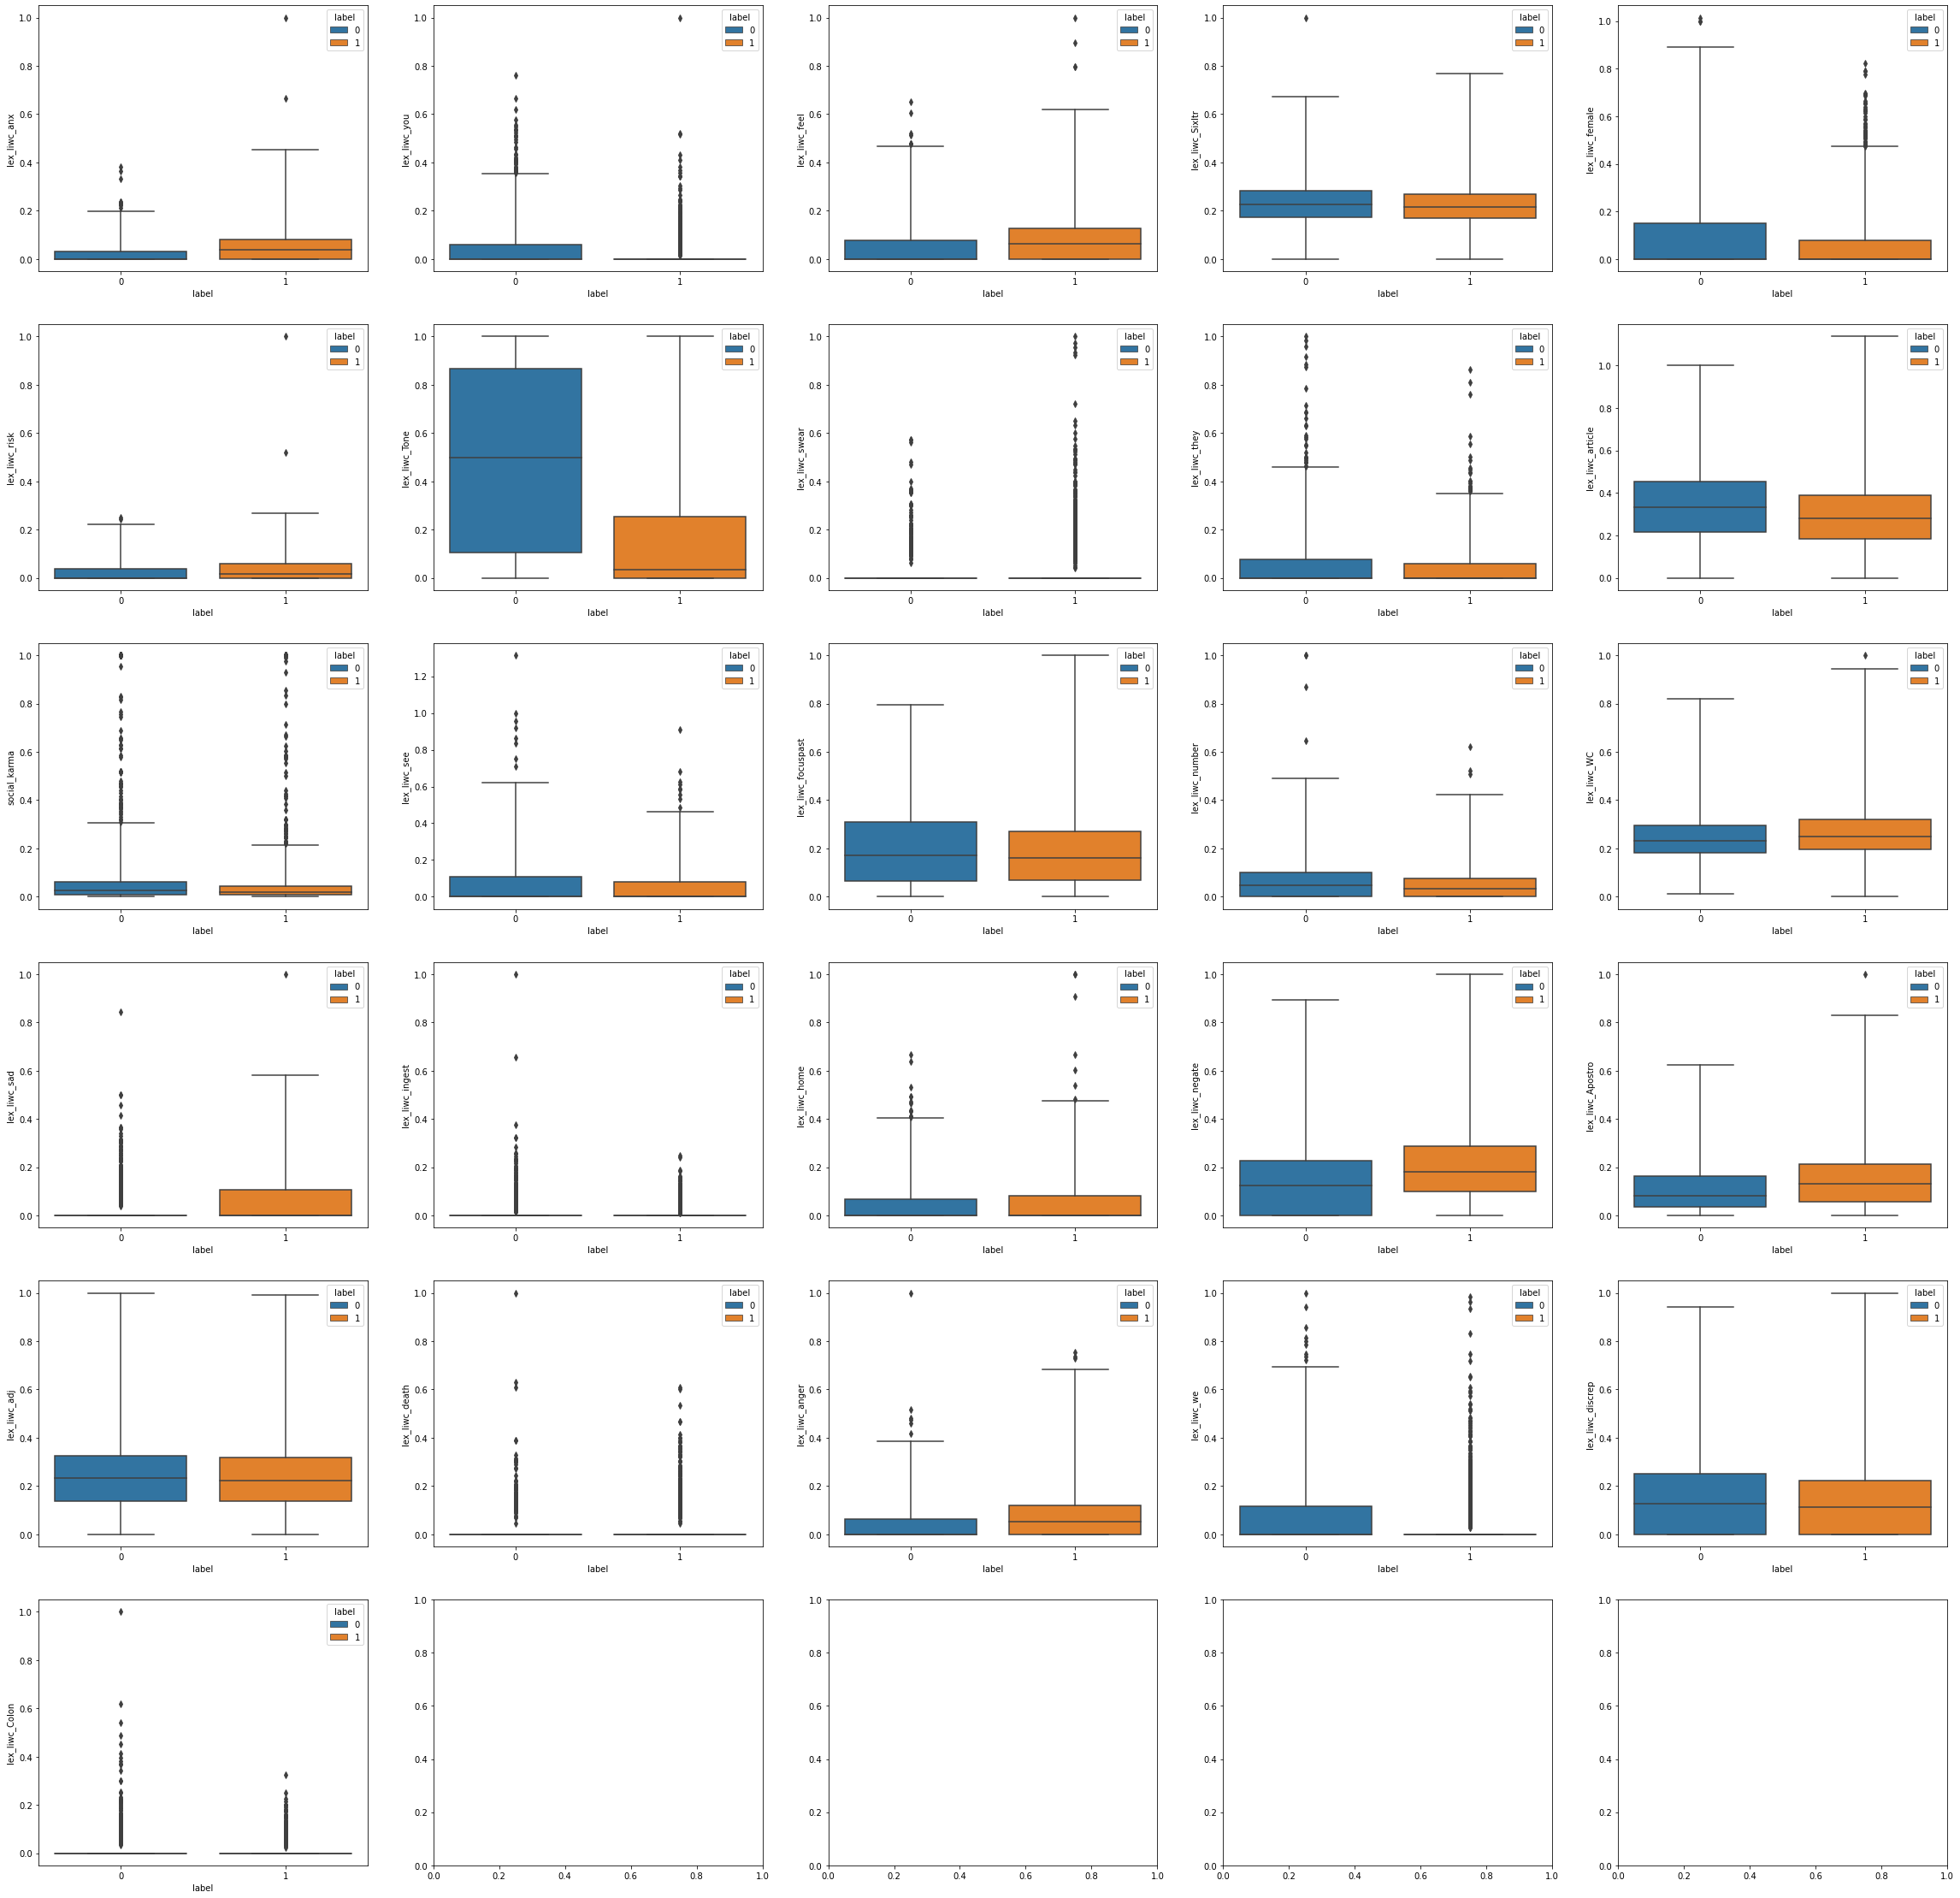

In [102]:
fig, axs = plt.subplots(nrows=6,ncols=5,figsize=(40,40) )

for (i,f) in zip(axs.flatten(),sign_feat_list[1:]):
    sns.boxplot(ax=i, hue=smf_data['label'], x=smf_data['label'], y=smf_data[f], whis=5, dodge=False)

fig.savefig('/Users/radulradulov/code/rradulov/dreaddit/images/var_boxplots.png')

In [112]:
final_list = ['lex_liwc_Tone', 'lex_liwc_negate', 'lex_liwc_anger', 'lex_liwc_anx']

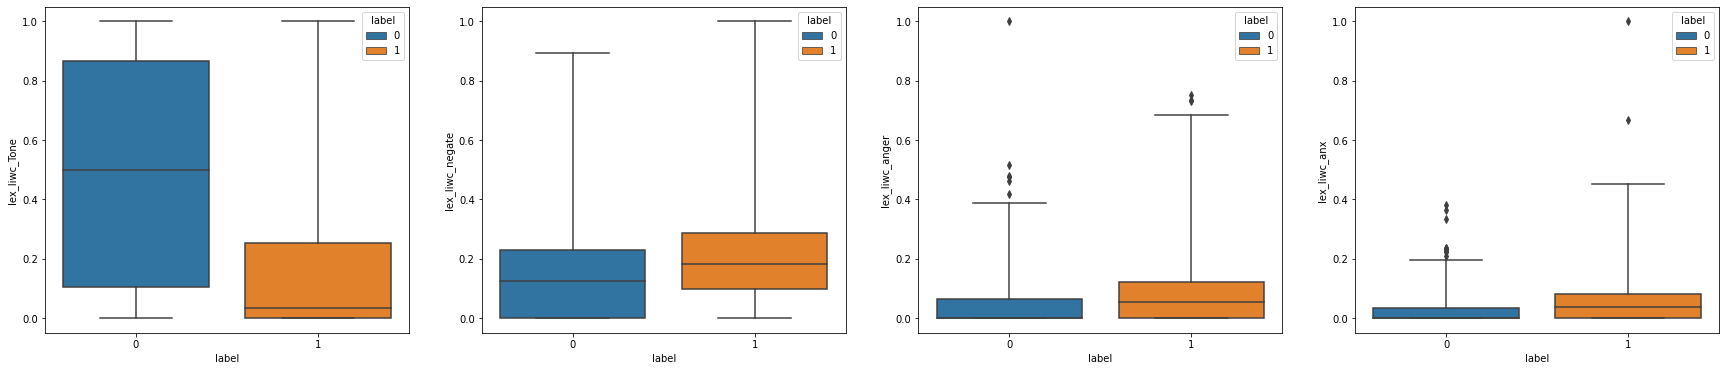

In [116]:
fig, axs = plt.subplots(nrows=1,ncols=4,figsize=(30,6) )

for (i,imp_f) in zip(axs.flatten(),final_list):
    sns.boxplot(ax=i, hue=smf_data['label'], x=smf_data['label'], y=smf_data[imp_f], whis=5, dodge=False)

fig.savefig('/Users/radulradulov/code/rradulov/dreaddit/images/var_boxplots1.png')

In [29]:
data = pd.concat([training_data, test_data])

In [30]:
data_train = pd.read_csv('../raw_data/dreaddit-train.csv', parse_dates=True)
data_test = pd.read_csv('../raw_data/dreaddit-test.csv', parse_dates=True)
data = pd.concat([data_train, data_test])

In [31]:
data['domain'] = data['subreddit'].map({'domesticviolence': 'abuse',
                                                   'survivorsofabuse': 'abuse',
                                                   'anxiety': 'anxiety',
                                                   'stress': 'anxiety',
                                                   'almosthomeless': 'ﬁnancial',
                                                   'assistance': 'ﬁnancial',
                                                   'food_pantry': 'ﬁnancial',
                                                   'homeless':'ﬁnancial',
                                                   'ptsd':'ptsd',
                                                   'relationships':'social'
                                                   })


In [32]:
stressed = data.loc[data['label']==1]['text']
non_stressed = data.loc[data['label']==0]['text']
stressed_corpus = " ".join(["".join(i) for i in stressed])
non_stressed_corpus = " ".join(["".join(i) for i in non_stressed])
from wordcloud import WordCloud, STOPWORDS
wordcloud_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(stressed_corpus)
wordcloud_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(non_stressed_corpus)

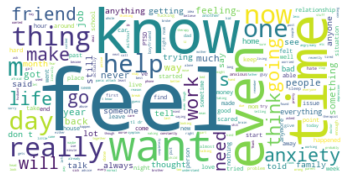

In [33]:
plt.imshow(wordcloud_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()

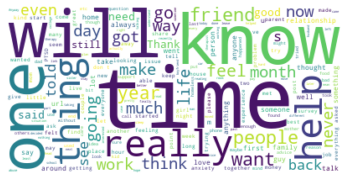

In [34]:
plt.imshow(wordcloud_non_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()

In [35]:
ptsd_non_stressed = data.loc[(data['domain']=='ptsd') & (data['label']==0)]['text']
ptsd_stressed = data.loc[(data['domain']=='ptsd') & (data['label']==1)]['text']

ﬁnancial_non_stressed = data.loc[(data['domain']=='ﬁnancial') & (data['label']==0)]['text']
ﬁnancial_stressed = data.loc[(data['domain']=='ﬁnancial') & (data['label']==1)]['text']

anxiety_non_stressed = data.loc[(data['domain']=='anxiety') & (data['label']==0)]['text']
anxiety_stressed = data.loc[(data['domain']=='anxiety') & (data['label']==1)]['text']

abuse_non_stressed = data.loc[(data['domain']=='abuse') & (data['label']==0)]['text']
abuse_stressed = data.loc[(data['domain']=='abuse') & (data['label']==1)]['text']

social_non_stressed = data.loc[(data['domain']=='social') & (data['label']==0)]['text']
social_stressed = data.loc[(data['domain']=='social') & (data['label']==1)]['text']

In [36]:
ptsd_non_stressed_corpus = " ".join(["".join(i) for i in ptsd_non_stressed])
ptsd_stressed_corpus = " ".join(["".join(i) for i in ptsd_stressed])

ﬁnancial_non_stressed_corpus = " ".join(["".join(i) for i in ﬁnancial_non_stressed])
ﬁnancial_stressed_corpus = " ".join(["".join(i) for i in ﬁnancial_stressed])
#ﬁnancial_corpus = " ".join(["".join(i) for i in ﬁnancial])

anxiety_non_stressed_corpus = " ".join(["".join(i) for i in anxiety_non_stressed])
anxiety_stressed_corpus = " ".join(["".join(i) for i in anxiety_stressed])

abuse_non_stressed_corpus = " ".join(["".join(i) for i in abuse_non_stressed])
abuse_stressed_corpus = " ".join(["".join(i) for i in abuse_stressed])

social_non_stressed_corpus = " ".join(["".join(i) for i in social_non_stressed])
social_stressed_corpus = " ".join(["".join(i) for i in social_stressed])

In [37]:
wordcloud_ptsd_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ptsd_non_stressed_corpus)
wordcloud_ptsd_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ptsd_stressed_corpus)

wordcloud_ﬁnancial_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ﬁnancial_non_stressed_corpus)
wordcloud_ﬁnancial_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ﬁnancial_stressed_corpus)
#wordcloud_ﬁnancial = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(ﬁnancial_corpus)

wordcloud_anxiety_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(anxiety_non_stressed_corpus)
wordcloud_anxiety_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(anxiety_stressed_corpus)
#wordcloud_anxiety = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(anxiety_corpus)

wordcloud_abuse_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(abuse_non_stressed_corpus)
wordcloud_abuse_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(abuse_stressed_corpus)
#wordcloud_abuse = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(abuse_corpus)

wordcloud_social_non_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(social_non_stressed_corpus)
wordcloud_social_stressed = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(social_stressed_corpus)
#wordcloud_social = WordCloud(max_font_size=100, max_words=1000, background_color="white", stopwords=STOPWORDS).generate(social_corpus)




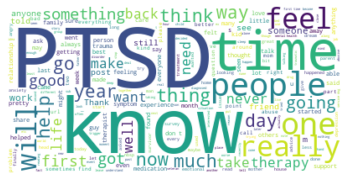

In [38]:
plt.imshow(wordcloud_ptsd_non_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_ptsd_non_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/ptsd_non_stressed.png');

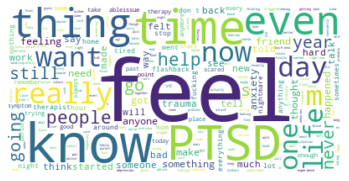

In [39]:
plt.imshow(wordcloud_ptsd_stressed, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_ptsd_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/ptsd_stressed.png');

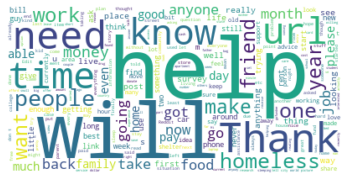

In [40]:
plt.imshow(wordcloud_ﬁnancial_non_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_ﬁnancial_non_stressed .to_file('/Users/radulradulov/code/rradulov/dreaddit/images/financial_non_stressed.png');

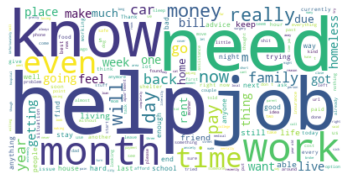

In [41]:
plt.imshow(wordcloud_ﬁnancial_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_ﬁnancial_stressed .to_file('/Users/radulradulov/code/rradulov/dreaddit/images/financial_stressed.png');

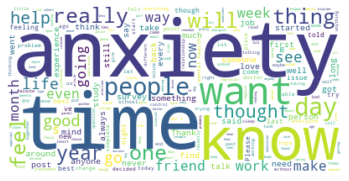

In [42]:
plt.imshow(wordcloud_anxiety_non_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_anxiety_non_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/anxiety_non_stressed.png');

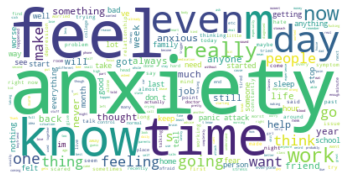

In [43]:
plt.imshow(wordcloud_anxiety_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_anxiety_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/anxiety_stressed.png');

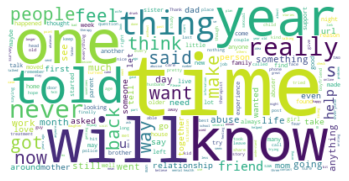

In [44]:
plt.imshow(wordcloud_abuse_non_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_abuse_non_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/abuse_non_stressed.png');

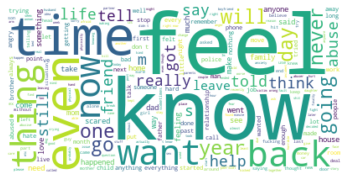

In [45]:
plt.imshow(wordcloud_abuse_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_abuse_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/abuse_stressed.png');

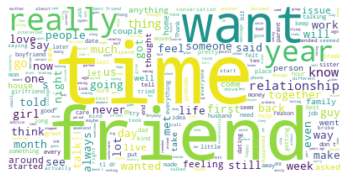

In [46]:
plt.imshow(wordcloud_social_non_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_social_non_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/social_non_stressed.png');

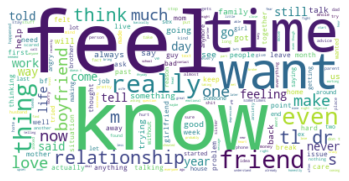

In [47]:
plt.imshow(wordcloud_social_stressed , interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud_social_stressed.to_file('/Users/radulradulov/code/rradulov/dreaddit/images/social_stressed.png');

### Testing various ML models

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
log_model = LogisticRegression(max_iter=1_000)

In [49]:
y_pred = log_model.fit(X_train,y_train).predict(X_test)

In [50]:
log_model.score(X_test,y_test)

0.7412587412587412

In [51]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
grid_log_reg = {'penalty': ['none'], #['l1', 'l2', 'elasticnet', 'none'],
                #'C':[0, 0.0001, 0.01, 1, 10, 100, 1000],
                'solver':['newton-cg', 'newton-cg', 'lbfgs'] }  #, 'sag', 'saga']}

log_search = RandomizedSearchCV(log_model, grid_log_reg, n_jobs=-1, cv=10, verbose=0, scoring='accuracy' )
log_search.fit(X_train,y_train, sample_weight = clean_train['confidence']) 

/Users/radulradulov/.pyenv/versions/3.8.12/envs/dreaddit/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
                   n_jobs=-1,
                   param_distributions={'penalty': ['none'],
                                        'solver': ['newton-cg', 'newton-cg',
                                                   'lbfgs']},
                   scoring='accuracy')

In [52]:
log_search.best_estimator_

LogisticRegression(max_iter=1000, penalty='none', solver='newton-cg')

In [53]:
log_search.best_score_

0.750098292937839

In [54]:
log_search.score(X_test, y_test)

0.7342657342657343

In [55]:
#Best model from the Grid Search
#LogisticRegression(C=1e-05, max_iter=1000, penalty='none', solver='newton-cg')
#0.7580419580419581

In [56]:
# from sklearn.feature_selection import SequentialFeatureSelector
# selector = SequentialFeatureSelector(LogisticRegression(max_iter=1_000), cv=10, n_jobs=-1, direction='backward',
#                                     n_features_to_select=0.6)
# selector.fit(X_train, y_train)
# selector.transform(X_train)
# len(selector.get_feature_names_out())
# X_train_selected = pd.DataFrame(columns = selector.get_feature_names_out(),
#                                 index = X_train.index,
#                                 data = selector.transform(X_train))
# X_test_selected = X_test[selector.get_feature_names_out()]

### SVC

In [57]:
from sklearn.svm import SVC

SVC_model = SVC()

gird_SVC = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
            'C':stats.uniform(0.01,10),
            'gamma':stats.loguniform(0.01,10)}

In [58]:
SVC_search = RandomizedSearchCV(SVC_model, gird_SVC, n_jobs=-1, cv=10, verbose=0, scoring='accuracy')
SVC_search.fit(X_train,y_train, sample_weight = clean_train['confidence']) 

RandomizedSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131d15220>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131c7ad30>,
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   scoring='accuracy')

In [59]:
SVC_search.best_estimator_

SVC(C=6.094836327713273, gamma=1.834070159775523, kernel='linear')

In [60]:
SVC_search.best_score_

0.747266460956552

In [61]:
SVC_search.score(X_test, y_test)

0.7496503496503496

### KNN

In [62]:
from sklearn.neighbors import KNeighborsClassifier

In [63]:
knn_model = KNeighborsClassifier()
grid_knn = {'n_neighbors':[2,3,4,5,6,7,8,9,10,12,15,20,25]}

In [64]:
knn_search =  RandomizedSearchCV(knn_model, grid_knn, cv=10, scoring='accuracy', verbose=1 )

In [65]:
knn_search.fit(X_train,y_train) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=KNeighborsClassifier(),
                   param_distributions={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9,
                                                        10, 12, 15, 20, 25]},
                   scoring='accuracy', verbose=1)

In [66]:
knn_search.best_estimator_

KNeighborsClassifier(n_neighbors=20)

In [67]:
knn_search.best_score_

0.7221893196635645

In [68]:
knn_search.score(X_test, y_test)

0.7328671328671329

### XGBoost

In [69]:
# from xgboost import XGBClassifier
# model_xgb = XGBClassifier(use_label_encoder=False) #eval_metric='error')

In [70]:
# grid_xgboost = {'n_estimators':range(10,300,10) ,
#                 'max_depth':[2,4,6,8,10,12,14,16,18,20],
#                 'learning_rate': stats.loguniform(0.01,0.5),
#                 'booster':['gbtree', 'gblinear', 'dart']
#                }

# search_xgboost = RandomizedSearchCV(model_xgb, grid_xgboost, cv=5,
#                                     scoring='accuracy', verbose=1,n_jobs=-1)



In [71]:
# search_xgboost.fit(X_train,y_train)

In [72]:
# search_xgboost.best_score_

In [73]:
# search_xgboost.best_estimator_

In [74]:
# search_xgboost.score(X_test, y_test)

### AdaBoost

In [75]:
# from sklearn.ensemble import AdaBoostClassifier  #,GradientBoostingClassifier
# ada_model = AdaBoostClassifier() #searching of the best estimator

In [76]:
# gird_ada = {'base_estimator':[LogisticRegression(C=1000, max_iter=1000, penalty='none', solver='newton-cg')],  # GradientBoostingClassifier()],
#             'learning_rate': stats.loguniform(0.01,0.5)}

In [77]:
# search_ada = RandomizedSearchCV(ada_model, gird_ada, cv=10, scoring='accuracy', verbose=0 )

In [78]:
# search_ada.fit(X_train, y_train)

In [79]:
# search_ada.best_score_

In [80]:
# search_ada.best_estimator_

In [81]:
# search_ada.score(X_test, y_test)

### Gradient Boosting

In [82]:
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier()


In [83]:
gird_gb = {'n_estimators':range(10,300,10),
           'learning_rate': stats.loguniform(0.01,0.5)}

In [84]:
search_gb = RandomizedSearchCV(gb_model, gird_gb, cv=10, scoring='accuracy', verbose=1, n_jobs=-1, refit=True )

In [85]:
search_gb.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x131b21a00>,
                                        'n_estimators': range(10, 300, 10)},
                   scoring='accuracy', verbose=1)

In [86]:
search_gb.best_score_

0.7359727268202857

In [87]:
search_gb.best_estimator_

GradientBoostingClassifier(learning_rate=0.13296629414377953, n_estimators=250)

In [88]:
search_gb.score(X_test, y_test)

0.7342657342657343

### Stacking Classifiers

In [89]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

ensamble = StackingClassifier( 
    estimators=[('log_reg',log_search.best_estimator_), 
                ('svc', SVC_search.best_estimator_), 
                ('gb', search_gb.best_estimator_)], n_jobs=-1)
    

In [90]:
from sklearn.model_selection import cross_val_score
ensamble_score = cross_val_score(ensamble, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)

In [91]:
ensamble_score.mean()

0.7472552630269249

In [92]:
ensamble.fit(X_train, y_train)

StackingClassifier(estimators=[('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   penalty='none',
                                                   solver='newton-cg')),
                               ('svc',
                                SVC(C=6.094836327713273,
                                    gamma=1.834070159775523, kernel='linear')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.13296629414377953,
                                                           n_estimators=250))],
                   n_jobs=-1)

In [93]:
ensamble.score(X_test, y_test)

0.7482517482517482

In [94]:
from sklearn.ensemble import BaggingClassifier

weak_learner = LogisticRegression() #log_search.best_estimator_
bagged_model = BaggingClassifier(weak_learner, n_estimators=30, verbose=0)

bagged_model.fit(X_train, y_train)
bagged_model.score(X_test, y_test)

0.7440559440559441